In [534]:
import numpy as rnp
import scipy.signal
import matplotlib.pyplot as plt

import jax
from jax.config import config
config.update("jax_enable_x64", True)
from jax import device_count

# Set CPU count for numpyro multi-chain multi-thread
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

import jax.random as jr
import jax.numpy as np
import dLux as dl
import matplotlib.pyplot as plt

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

# Set global plotting parameters
%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'serif'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

In [535]:
def blurred_point_model(x, y, flux):
    size_x = 15
    size_y = 15
    
    x = x + (size_x - 1) / 2
    y = y + (size_y - 1) / 2
    
    # Create a 15x15 grid of coordinates
    xx, yy = np.meshgrid(np.arange(size_x), np.arange(size_y))
    
    # Calculate the distance from each pixel to the center of the point
    r = np.sqrt((xx - x)**2 + (yy - y)**2)
    
    # Create a Gaussian kernel with standard deviation of 2 pixels
    kernel = np.exp(-r**2 / (0.6 * 2**2))
    
    # Normalize the kernel so that the maximum value is 1
    kernel /= np.max(kernel)
    
    # Create a 15x15 image with the blurred point
    image = flux * kernel
    
    return image

In [536]:
#lets make some fake data 

true_x = 2
true_y = -4
true_flux = 0.5

yerr = 0.03 # why yerr?
image = blurred_point_model(true_x, true_y, true_flux)
_photon =  yerr * jr.poisson(jr.PRNGKey(0), image)
_noise = yerr*jr.normal(jr.PRNGKey(0), image.shape)


In [537]:
data = image + _photon + _noise

In [538]:

data_err = 0.2 * np.ones_like(data.flatten())

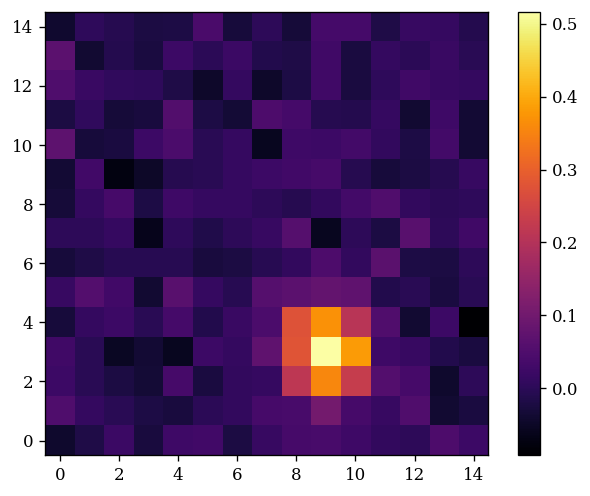

In [539]:
plt.imshow(data)
plt.colorbar()
plt.show()

In [540]:
def image_model(data_err, data=None):
    # These are the parameters that we're fitting and we're required to define explicit
    # priors using distributions from the numpyro.distributions module.
    
    #theta = npy.sample("theta", dist.Uniform(0, 2*np.pi))
    #rho = npy.sample("rho", dist.Uniform(0, 10))

    # Transformed parameters (and other things!) can be tracked during sampling using
    # "deterministics" as follows:
    
    #x = npy.deterministic("x", rho*np.cos(theta))
    #y = npy.deterministic("y", rho*np.sin(theta))
    
    x = npy.sample("x", dist.Uniform(-5, 5))
    y = npy.sample("y", dist.Uniform(-5, 5))
    
    flux = npy.sample("flux", dist.Uniform(0, 5))

    # Then we specify the sampling distribution for the data, or the likelihood function.
    # Here we're using a numpyro.plate to indicate that the data are independent. This
    # isn't actually necessary here and we could have equivalently omitted the plate since
    # the Normal distribution can already handle vector-valued inputs. But, it's good to
    # get into the habit of using plates because some inference algorithms or distributions
    # can take advantage of knowing this structure.
    with npy.plate("data", len(data.flatten())):
        npy.sample("img", dist.Normal(blurred_point_model(x, y, flux).flatten(), data_err), obs=data.flatten())
    

In [541]:
sampler = npy.infer.MCMC(
    npy.infer.NUTS(image_model),    
    num_warmup=2000,
    num_samples=2000,
    num_chains=device_count(),
    progress_bar=True,
)
%time sampler.run(jr.PRNGKey(0), data_err, data)

sample: 100%|█| 4000/4000 [00:02<00:00, 1906.50it/s, 7 steps of size 5.82e-01. a


CPU times: user 2.22 s, sys: 61.2 ms, total: 2.28 s
Wall time: 2.26 s


In [542]:
sampler.print_summary()
values_out = sampler.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      flux      0.47      0.10      0.46      0.29      0.62   1221.47      1.00
         x      2.03      0.34      2.02      1.45      2.56    910.57      1.00
         y     -3.95      0.33     -3.95     -4.51     -3.40   1234.88      1.00

Number of divergences: 0


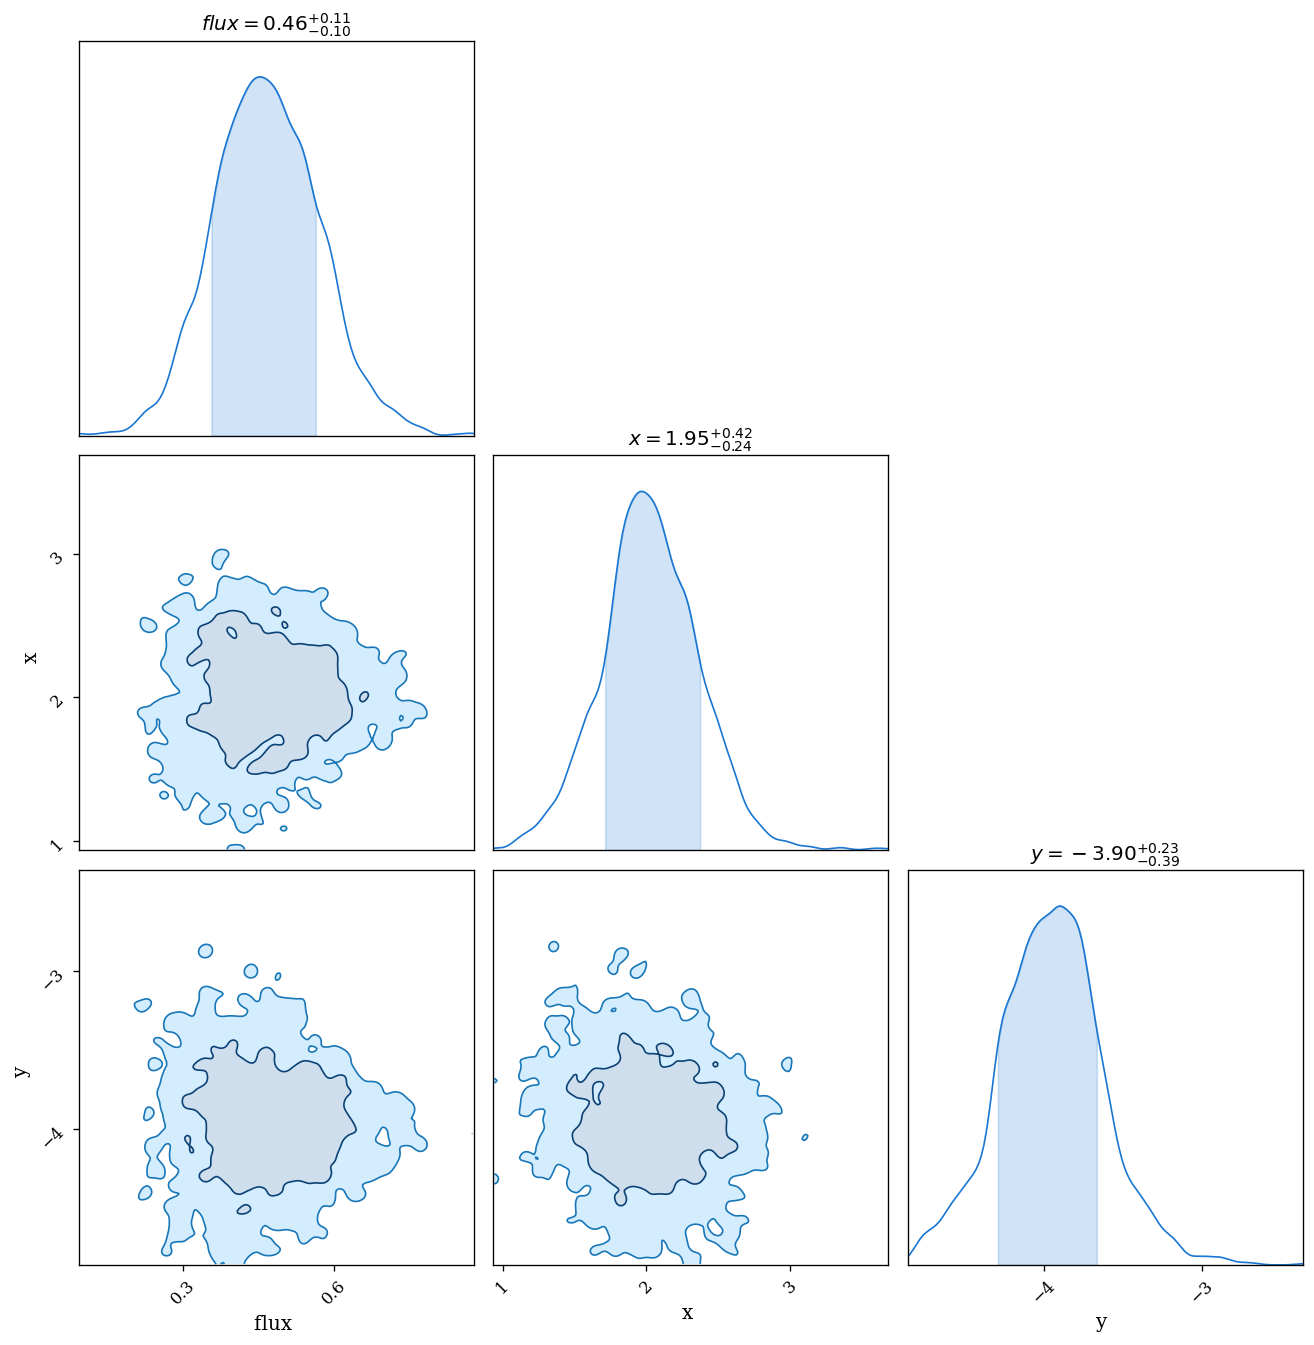

In [543]:
import chainconsumer as cc

chain = cc.ChainConsumer()
chain.add_chain(values_out)
chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = chain.plotter.plot()
fig.set_size_inches((12,12));

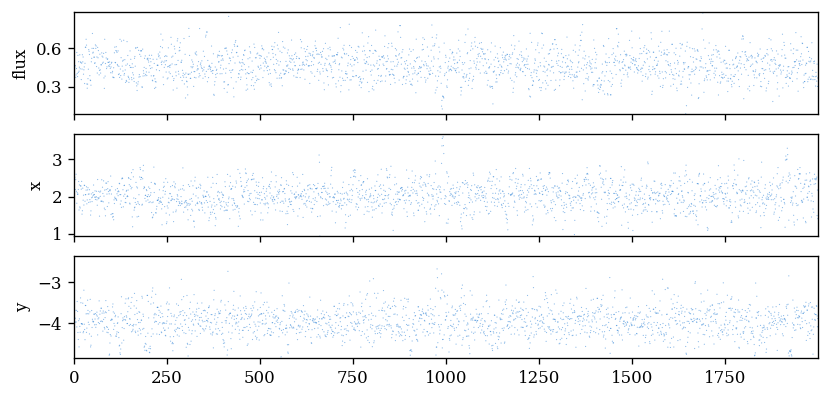

In [544]:
fig = chain.plotter.plot_walks()
#fig.set_size_inches((12,12));